In [100]:
#1D non-isothermal
#I think we should still convert it to molar flowrates somehow!!!

'''NEED TO REDO THE A/V CALCULATION AND CONFIRM THE JOULE HEATING EQUATION'''

from scipy.integrate import solve_bvp
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#heats of reaction calculation

T = 900 #soln.y[6]
t = T/1000

Hch4 = -76.84376 - 0.703029*t + 54.23865*t**2 - 14.173857*t**3 + 1.465697*t**4 - 0.678565/t 
Hh2o = -250.881 + 30.092*t + 3.416255*t**2 + 2.2644783*t**3 - 0.63362*t**4 - 0.082139/t
Hco = -8785.2438 + 29061.55000*t + 103.869500*t**2 + 25474.58869/(np.exp(3.09921/t)-1)
Hco2 = -399.9266-11.401074*t-27.615766*t**2+1.7163693*t**3-0.072895*t**4-0.110128/t+77.289951*t*np.sqrt(t) 
Hh2 = 0

# Compare above which I dont think is correct (from https://old.vscht.cz/fch/cz/pomucky/fchab/Shomate.html) to below
# from: NIST but inspiration came from here: https://kitchingroup.cheme.cmu.edu/blog/2013/02/01/Water-gas-shift-equilibria-via-the-NIST-Webbook/

A =   24.99735
B =   55.18696
C =  -33.69137
D =   7.948387
E =  -0.136638
F =  -403.6075
G =   228.2431
H =  -393.5224

dH_CO2 = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H

print(dH_CO2)

dHsmr = 3*Hh2 + Hco - Hch4 - Hh2o
dHwgs = Hh2 + Hco2 - Hco - Hh2o

print(dHsmr)
print(dHwgs)

Cph2o = 30.092 + 6.83251*t + 6.793435*t**2 - 2.53448*t**3 + 0.082139/t**2
print(Cph2o)

-365.4839776354861
28.031785067675003
18558.631115966364
-18440.672430125727
39.9977116028395


In [102]:
#WANT TO RE-ARANGE CONSTANTS

#reactor constants
L = 0.0609 #m
R_inner = 2.39/1000 #m
R_outer = 3.5/1000 #m

A = np.pi * ((R_outer*100)**2-(R_inner*100)**2) #cm^2 MIGHT HAVE TO ADJUST THE AREA CALC A BIT
V = A*L/(100**2) #m^3
S = 2*np.pi*R_outer*L #m^2

h2Removal = 0 #change to 1 if there is removal of hydrogen

#gas flow constants
Tin = 622+273 #K
P = 1 #bar or atm

sccm0 = np.array([16.16, 48.48, 0, 0, 10, 5])
mols0 = sccm0/22400 * 60
y0 = mols0/sum(mols0)
y0 = np.concatenate((y0, [Tin]))
print(y0)

u0 = sum(sccm0) * 273 / Tin * P / 1 / 60 #cm^3/sec
v0 = u0 / A / 100 #m/sec

#rate equation constants
Rgas = 8.314 #J / mol·K
Easmr = 165.740 #kJ/mol
Asmr = 1.68*10**8
Eawgs = 89.23 #kJ/mol
Awgs = 9.90*10**3

Ku = 1

I = 9 #curent in Amps
F = 96485 #faradays constant

Cpg = 30 #J/mol·K

dHsmr = 18558.63*10**3 #J/mol
dHwgs = -18440.67*10**3 #J/mol

U = 0.116 #J (s K)^-1.
Ts = 298 #K

Iheat = 1
Resist = 20

[2.02913109e-01 6.08739327e-01 0.00000000e+00 0.00000000e+00
 1.25565043e-01 6.27825213e-02 8.95000000e+02]


In [103]:
x_num = 10

x_pts = np.linspace(0,L,x_num)

#initial guess array
init_guess = np.zeros((7, x_num))
init_guess[6, :] = Tin+10

init_guess[0, :] = 0.2
init_guess[1, :] = 0.6  
init_guess[2, :] = 0
init_guess[3, :] = 0    
init_guess[4, :] = 0.1

def enthalpy(T):
    t = T/1000

    Hch4 = -76.84376 - 0.703029*t + 54.23865*t**2 - 14.173857*t**3 + 1.465697*t**4 - 0.678565/t 
    Hh2o = -250.881 + 30.092*t + 3.416255*t**2 + 2.2644783*t**3 - 0.63362*t**4 - 0.082139/t
    Hco = -8785.2438 + 29061.55000*t + 103.869500*t**2 + 25474.58869/(np.exp(3.09921/t)-1)
    Hco2 = -399.9266-11.401074*t-27.615766*t**2+1.7163693*t**3-0.072895*t**4-0.110128/t+77.289951*t*np.sqrt(t) 
    Hh2 = 0

    dHsmr = 3*Hh2 + Hco - Hch4 - Hh2o
    dHwgs = Hh2 + Hco2 - Hco - Hh2o

    # return dHsmr*10**3, dHwgs*10**3 #J/mol
    return 18558.63*10**3, -18440.67*10**3

def odes(x, y): #dy/dt = f(x)
    #NEED TO ADJUST THIS. THESE ARE NOT CONCENTRATIONS, THEY ARE MOL FRACTIONS
    Cch4 = y[0]
    Ch2o = y[1]
    Cco = y[2]
    Cco2 = y[3]
    Ch2 = y[4]
    T = y[6]
    print(T)

    Keqsmr = (101325/100000)**2 * np.exp(-26830/T + 30.114)
    Keqwgs = np.exp(4400/T - 4.036)
    Ctot = P/(8.3144598 * 10**-5 * T)

    '''the velocity would also be dependent on the temperature'''
    v = v0*(3*y0[0] - 2*Cch4)/y0[0] # v0*(1+2X)
    # print(len(v))
    
    '''NEED TO REDO THE A/V CALCULATION'''
    rsmr = 2/R_outer*Ku*Asmr*np.exp(-Easmr*1000/Rgas/T)*(Cch4*Ch2o-(P**2)*Cco*(Ch2**3)/Keqsmr)/Ctot
    rwgs = 2/R_outer*Ku*Awgs*np.exp(-Eawgs*1000/Rgas/T)*(Ch2o*Cco-Cco2*Ch2/Keqwgs)/Ctot
    rh2r = I/(2*F*L)/Ctot #have not confirmed if this is correct

    dHsmr, dHwgs = enthalpy(T)

    ch4 = (-rsmr)/v
    h2o = (-rsmr - rwgs)/v
    co = (rsmr - rwgs)/v
    co2 = (rwgs)/v
    h2 = (3*rsmr + rwgs + h2Removal*rh2r)/v
    ar = np.zeros(len(Cch4))
    #heat capacities are in kJ/mol so then 
    Temp = (S*U*(-T[:] + Ts) - S*(dHsmr*rsmr + dHwgs*rwgs) + Iheat**2 * Resist)/(v*Ctot*Cpg*V)
    
    return np.vstack([ch4, h2o, co, co2, h2, ar, Temp])

def bcs(yleft, yright):
    return np.array(yleft-y0)   #ADD THE TEMPERATURE IN y0 BX ALSO NEEDS TO BE BC

soln = solve_bvp(odes, bcs, x_pts, init_guess, max_nodes=100, tol = 0.01)

[905. 905. 905. 905. 905. 905. 905. 905. 905. 905.]
[905. 905. 905. 905. 905. 905. 905. 905. 905. 905.]
[905. 905. 905. 905. 905. 905. 905. 905. 905.]
[905. 905. 905. 905. 905. 905. 905. 905. 905. 905.]
[905. 905. 905. 905. 905. 905. 905. 905. 905. 905.]
[905. 905. 905. 905. 905. 905. 905. 905. 905. 905.]
[905. 905. 905. 905. 905. 905. 905. 905. 905. 905.]
[905. 905. 905. 905. 905. 905. 905. 905. 905. 905.]
[905. 905. 905. 905. 905. 905. 905. 905. 905. 905.]
[905.0000135 905.0000135 905.0000135 905.0000135 905.0000135 905.0000135
 905.0000135 905.0000135 905.0000135 905.0000135]
[905. 905. 905. 905. 905. 905. 905. 905. 905.]
[905. 905. 905. 905. 905. 905. 905. 905. 905.]
[905. 905. 905. 905. 905. 905. 905. 905. 905.]
[905. 905. 905. 905. 905. 905. 905. 905. 905.]
[905. 905. 905. 905. 905. 905. 905. 905. 905.]
[905. 905. 905. 905. 905. 905. 905. 905. 905.]
[905.0000135 905.0000135 905.0000135 905.0000135 905.0000135 905.0000135
 905.0000135 905.0000135 905.0000135]
[895.         898.867

C:\Users\Alexa\AppData\Local\Temp\ipykernel_5264\2622332537.py:21: RuntimeWarning: invalid value encountered in sqrt
  Hco2 = -399.9266-11.401074*t-27.615766*t**2+1.7163693*t**3-0.072895*t**4-0.110128/t+77.289951*t*np.sqrt(t)
C:\Users\Alexa\AppData\Local\Temp\ipykernel_5264\2622332537.py:20: RuntimeWarning: divide by zero encountered in divide
  Hco = -8785.2438 + 29061.55000*t + 103.869500*t**2 + 25474.58869/(np.exp(3.09921/t)-1)


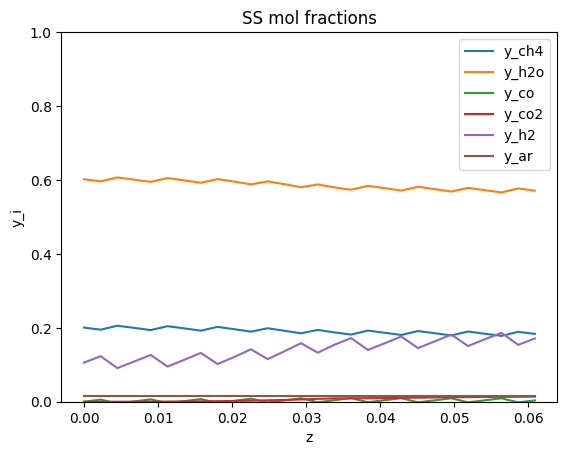

In [104]:
plt.plot(soln.x, soln.y[0], label='y_ch4')
plt.plot(soln.x, soln.y[1], label='y_h2o')
plt.plot(soln.x, soln.y[2], label='y_co')
plt.plot(soln.x, soln.y[3], label='y_co2')
plt.plot(soln.x, soln.y[4], label='y_h2')
plt.plot(soln.x, soln.y[5], label='y_ar')
plt.ylim(0, 1)
plt.xlabel('z')
plt.ylabel('y_i')
plt.title('SS mol fractions')
plt.legend()

Text(0.5, 1.0, 'Temperature profile')

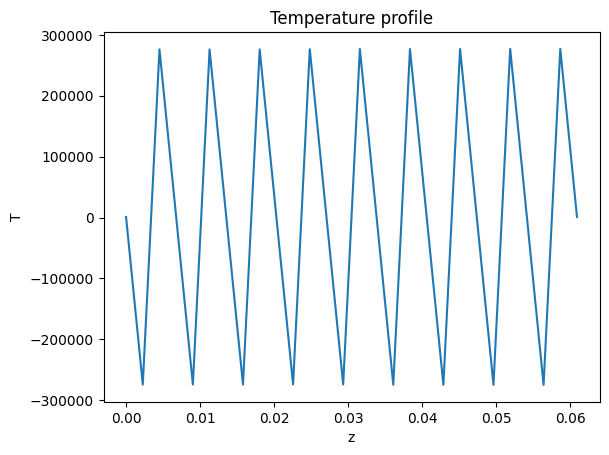

In [105]:
plt.plot(soln.x, soln.y[6])
plt.xlabel('z')
plt.ylabel('T')
plt.title('Temperature profile')